MIT license notice
© 2024 Saurabh Pathak. All rights reserved
Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated
documentation files (the "Software"), to deal in the Software without restriction, including without limitation the
rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit
persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the
Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE
WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR
COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR
OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.

## Demo notebook
© 2024 Saurabh Pathak. All rights reserved

In [1]:
import os

import keras_tuner
import tensorflow as tf
from easydict import EasyDict as Config

import dataloader
import hypermodels
import tune
import util

for gpu in tf.config.list_physical_devices('GPU'):
    tf.config.experimental.set_memory_growth(gpu, True)
tf.config.optimizer.set_jit(True)

2024-07-15 13:49:19.311648: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-15 13:49:19.332414: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-15 13:49:19.332431: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-15 13:49:19.332446: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-15 13:49:19.336900: I tensorflow/core/platform/cpu_feature_g

First, we will define some hyperparameters for the purpose of this notebook, that we will keep fixed throughout:

We use a fixed batchsize of 128 on a FC architecture with 5 hidden layers with biases having 500 units each. We will use the CIFAR10 dataset. Batchnorm is not used and tanh is the hidden layer activation function. Projection layer weights use orthogonal initialization. Data will be scaled using standard scalar. In this notebook, we will only tune for the lowest possible training error.

In [26]:
config = Config()
config.dataset = 'cifar10'
config.batchsize = 128
config.objective = 'error_rate'
config.histogram_freq = 0
config.use_bias = True
config.scale_data = 'standard'
config.weight_decay = 0.
config.init_fw_weight_aligned = False
config.reg_rate = False

hp = keras_tuner.HyperParameters()
config.bw_init = hp.Fixed('F', 'ortho')
config.arch = hp.Fixed('arch', '500-500-500-500-500')
config.batchnorm = hp.Fixed('bn', False)
config.activation = hp.Fixed('act', 'tanh')

hc = hypermodels.HyperModel

### Classification
Next, we will address the classification problem on this dataset. First, we need to find the best learning rate for each of the training algorithms. To that end, we will train for 50 epochs on a small subset of the dataset and use early stopping. For each setting of the learning rate, we will take the best error rate of 3 trials. Then the best learning rate will be the best out of all learning rates considered. For the local loss algorithm, categorical crossentropy will be used (cce).

In [27]:
config.problem_type = 'classification'
config.algorithm = hp.Choice('algo', 'bp dfa drtp cce'.split())
config.executions_per_trial = 3
config.examples_frac = .3
config.trackers = []
config.epochs = 50
config.use_early_stopping = True
config.n_classes = dataloader.get_n_classes(config)
lr = hp.Float('lr', min_value=1e-4, max_value=.1, step=10, sampling='log')

In [3]:
config.project_name = tune.create_project_name(config, hp)
util.ensure_empty_dir(config.project_name)

tuner = tune.run_tuner(config, hc, hp=hp)
tuner.results_summary()

Trial 16 Complete [00h 00m 12s]
error_rate: 88.6396001180013

Best error_rate So Far: 2.3415242433547974
Total elapsed time: 00h 08m 45s
Results summary
Results in ./cifar10_error_rate_ortho_500-500-500-500-500
Showing 10 best trials
Objective(name="error_rate", direction="min")

Trial 745574 summary
Hyperparameters:
F: ortho
arch: 500-500-500-500-500
bn: False
act: tanh
algo: cce
lr: 0.001
Score: 2.3415242433547974

Trial 738862 summary
Hyperparameters:
F: ortho
arch: 500-500-500-500-500
bn: False
act: tanh
algo: bp
lr: 0.0001
Score: 5.295138915379842

Trial 930443 summary
Hyperparameters:
F: ortho
arch: 500-500-500-500-500
bn: False
act: tanh
algo: dfa
lr: 0.0001
Score: 8.328881740570068

Trial 554246 summary
Hyperparameters:
F: ortho
arch: 500-500-500-500-500
bn: False
act: tanh
algo: bp
lr: 0.001
Score: 13.06980069478353

Trial 649324 summary
Hyperparameters:
F: ortho
arch: 500-500-500-500-500
bn: False
act: tanh
algo: dfa
lr: 0.001
Score: 15.889868100484213

Trial 679292 summary
H

`tuner.histories` object contains the hyperparams and learning trajectories of all the models built and tried in this experiment. We will parse it in a dataframe to find the best learning rate for each algorithm as described previously.

In [7]:
import numpy as np
import pandas as pd

data = []
for item in tuner.histories:
    hpset = item['hp']
    algo = hpset['algo']
    lr = hpset['lr']
    trials = item['histories']
    minmin_error = np.inf
    
    # find the minimum error obtained across trials
    for t in trials:
        min_error = min(t.history['error_rate'])
        minmin_error = min(minmin_error, min_error)
    data.append(dict(algo=algo, lr=lr, error=minmin_error))

df = pd.DataFrame.from_records(data)

# best learning rate for each algorithm
best_lr = df.groupby('algo', sort=False).min().reset_index()
best_lr

,algo,lr,error
0,bp,0.0001,3.498932
1,dfa,0.0001,7.705662
2,drtp,0.0001,31.236645
3,cce,0.0001,1.716079


It appears that the best learning rate for all the algorithms on this dataset is $10^{-4}$. Let's now train further on the best learning rates and plot the result. We will now run 5 trials per hyperparameter set. Each trial will run for 200 epochs, with no early stopping. We will additionally record two tracker metrics.

In [58]:
config.executions_per_trial = 5
config.examples_frac = 0.
config.trackers = ['bp_cosine', 'weight_alignment']
config.epochs = 200
config.use_early_stopping = False

# fix the learning rate
hp_config = hp.get_config()
hp_config['space'] = [d for d in hp_config['space'] if d['config']['name'] != 'lr']
hp = keras_tuner.HyperParameters.from_config(hp_config)
hp.Fixed('lr', 1e-4)

config.project_name = tune.create_project_name(config, hp)
util.ensure_empty_dir(config.project_name)

tuner = tune.run_tuner(config, hc, hp=hp)
tuner.results_summary()

Trial 3 Complete [00h 25m 27s]
error_rate: 40.151441955566405

Best error_rate So Far: 0.3926281988620758
Total elapsed time: 01h 06m 22s

Search: Running Trial #4

Value             |Best Value So Far |Hyperparameter
ortho             |ortho             |F
500-500-500-500...|500-500-500-500...|arch
False             |False             |bn
tanh              |tanh              |act
cce               |bp                |algo
0.0001            |0.0001            |lr

Epoch 1/200
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (128, 500)                1536500   
                                                                 
 activation (Activation)     (128, 500)                0         
                                                                 
 dense_1 (Dense)             (128, 500)                250500    
                                          

390/390 [==============================] - 2s 4ms/step - loss: 0.9441 - error_rate: 31.6346 - DenseOut/weight_alignment: 0.0338 - layer/bp_cosine: 0.6527 - layer/weight_alignment: 0.0000e+00 - layer_1/bp_cosine: 0.5695 - layer_1/weight_alignment: 0.3194 - layer_2/bp_cosine: 0.5586 - layer_2/weight_alignment: 0.1858 - layer_3/bp_cosine: 0.5042 - layer_3/weight_alignment: 0.1508 - layer_4/bp_cosine: 0.4587 - layer_4/weight_alignment: 0.1247 - val_loss: 1.5853 - val_error_rate: 49.4692
Epoch 29/200
390/390 [==============================] - 2s 4ms/step - loss: 0.9284 - error_rate: 31.2179 - DenseOut/weight_alignment: 0.0342 - layer/bp_cosine: 0.6493 - layer/weight_alignment: 0.0000e+00 - layer_1/bp_cosine: 0.5758 - layer_1/weight_alignment: 0.3252 - layer_2/bp_cosine: 0.5667 - layer_2/weight_alignment: 0.1899 - layer_3/bp_cosine: 0.5111 - layer_3/weight_alignment: 0.1550 - layer_4/bp_cosine: 0.4637 - layer_4/weight_alignment: 0.1285 - val_loss: 1.5547 - val_error_rate: 48.7179
Epoch 30/20

390/390 [==============================] - 2s 4ms/step - loss: 0.4308 - error_rate: 14.3770 - DenseOut/weight_alignment: 0.0426 - layer/bp_cosine: 0.5162 - layer/weight_alignment: 0.0000e+00 - layer_1/bp_cosine: 0.5612 - layer_1/weight_alignment: 0.4496 - layer_2/bp_cosine: 0.6734 - layer_2/weight_alignment: 0.2874 - layer_3/bp_cosine: 0.6980 - layer_3/weight_alignment: 0.2779 - layer_4/bp_cosine: 0.6387 - layer_4/weight_alignment: 0.2534 - val_loss: 2.1674 - val_error_rate: 50.4107
Epoch 61/200
390/390 [==============================] - 2s 4ms/step - loss: 0.4206 - error_rate: 14.1767 - DenseOut/weight_alignment: 0.0427 - layer/bp_cosine: 0.5103 - layer/weight_alignment: 0.0000e+00 - layer_1/bp_cosine: 0.5580 - layer_1/weight_alignment: 0.4521 - layer_2/bp_cosine: 0.6736 - layer_2/weight_alignment: 0.2893 - layer_3/bp_cosine: 0.7012 - layer_3/weight_alignment: 0.2811 - layer_4/bp_cosine: 0.6439 - layer_4/weight_alignment: 0.2567 - val_loss: 2.1866 - val_error_rate: 50.2204
Epoch 62/20

390/390 [==============================] - 2s 4ms/step - loss: 0.1584 - error_rate: 5.1202 - DenseOut/weight_alignment: 0.0440 - layer/bp_cosine: 0.3629 - layer/weight_alignment: 0.0000e+00 - layer_1/bp_cosine: 0.3899 - layer_1/weight_alignment: 0.5029 - layer_2/bp_cosine: 0.5855 - layer_2/weight_alignment: 0.3310 - layer_3/bp_cosine: 0.7135 - layer_3/weight_alignment: 0.3506 - layer_4/bp_cosine: 0.7541 - layer_4/weight_alignment: 0.3298 - val_loss: 3.1488 - val_error_rate: 51.6927
Epoch 93/200
390/390 [==============================] - 1s 4ms/step - loss: 0.1494 - error_rate: 4.8678 - DenseOut/weight_alignment: 0.0439 - layer/bp_cosine: 0.3518 - layer/weight_alignment: 0.0000e+00 - layer_1/bp_cosine: 0.3879 - layer_1/weight_alignment: 0.5039 - layer_2/bp_cosine: 0.5840 - layer_2/weight_alignment: 0.3321 - layer_3/bp_cosine: 0.7132 - layer_3/weight_alignment: 0.3523 - layer_4/bp_cosine: 0.7568 - layer_4/weight_alignment: 0.3316 - val_loss: 3.2131 - val_error_rate: 51.6526
Epoch 94/200


390/390 [==============================] - 2s 4ms/step - loss: 0.0494 - error_rate: 1.5024 - DenseOut/weight_alignment: 0.0405 - layer/bp_cosine: 0.2474 - layer/weight_alignment: 0.0000e+00 - layer_1/bp_cosine: 0.2694 - layer_1/weight_alignment: 0.5244 - layer_2/bp_cosine: 0.4776 - layer_2/weight_alignment: 0.3531 - layer_3/bp_cosine: 0.6663 - layer_3/weight_alignment: 0.3831 - layer_4/bp_cosine: 0.7953 - layer_4/weight_alignment: 0.3602 - val_loss: 4.3110 - val_error_rate: 52.6542
Epoch 125/200
390/390 [==============================] - 1s 4ms/step - loss: 0.0519 - error_rate: 1.5304 - DenseOut/weight_alignment: 0.0401 - layer/bp_cosine: 0.2550 - layer/weight_alignment: 0.0000e+00 - layer_1/bp_cosine: 0.2711 - layer_1/weight_alignment: 0.5247 - layer_2/bp_cosine: 0.4830 - layer_2/weight_alignment: 0.3536 - layer_3/bp_cosine: 0.6685 - layer_3/weight_alignment: 0.3838 - layer_4/bp_cosine: 0.7967 - layer_4/weight_alignment: 0.3608 - val_loss: 4.2859 - val_error_rate: 52.8746
Epoch 126/20

390/390 [==============================] - 2s 4ms/step - loss: 0.0195 - error_rate: 0.5649 - DenseOut/weight_alignment: 0.0376 - layer/bp_cosine: 0.2086 - layer/weight_alignment: 0.0000e+00 - layer_1/bp_cosine: 0.2301 - layer_1/weight_alignment: 0.5321 - layer_2/bp_cosine: 0.4436 - layer_2/weight_alignment: 0.3681 - layer_3/bp_cosine: 0.6534 - layer_3/weight_alignment: 0.3978 - layer_4/bp_cosine: 0.7984 - layer_4/weight_alignment: 0.3749 - val_loss: 4.9272 - val_error_rate: 52.3137
Epoch 157/200
390/390 [==============================] - 1s 4ms/step - loss: 0.0202 - error_rate: 0.5729 - DenseOut/weight_alignment: 0.0376 - layer/bp_cosine: 0.2030 - layer/weight_alignment: 0.0000e+00 - layer_1/bp_cosine: 0.2337 - layer_1/weight_alignment: 0.5323 - layer_2/bp_cosine: 0.4551 - layer_2/weight_alignment: 0.3688 - layer_3/bp_cosine: 0.6578 - layer_3/weight_alignment: 0.3984 - layer_4/bp_cosine: 0.8012 - layer_4/weight_alignment: 0.3755 - val_loss: 4.9295 - val_error_rate: 52.4539
Epoch 158/20

390/390 [==============================] - 1s 4ms/step - loss: 0.0106 - error_rate: 0.3245 - DenseOut/weight_alignment: 0.0365 - layer/bp_cosine: 0.2048 - layer/weight_alignment: 0.0000e+00 - layer_1/bp_cosine: 0.2427 - layer_1/weight_alignment: 0.5354 - layer_2/bp_cosine: 0.4802 - layer_2/weight_alignment: 0.3804 - layer_3/bp_cosine: 0.6664 - layer_3/weight_alignment: 0.4045 - layer_4/bp_cosine: 0.7977 - layer_4/weight_alignment: 0.3825 - val_loss: 5.1468 - val_error_rate: 52.3438
Epoch 189/200
390/390 [==============================] - 2s 4ms/step - loss: 0.0102 - error_rate: 0.2945 - DenseOut/weight_alignment: 0.0363 - layer/bp_cosine: 0.1889 - layer/weight_alignment: 0.0000e+00 - layer_1/bp_cosine: 0.2351 - layer_1/weight_alignment: 0.5355 - layer_2/bp_cosine: 0.4756 - layer_2/weight_alignment: 0.3809 - layer_3/bp_cosine: 0.6701 - layer_3/weight_alignment: 0.4049 - layer_4/bp_cosine: 0.7982 - layer_4/weight_alignment: 0.3828 - val_loss: 5.1643 - val_error_rate: 52.5140
Epoch 190/20

                                                                 
Total params: 2543510 (9.70 MB)
Trainable params: 2543510 (9.70 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
390/390 [==============================] - 4s 5ms/step - loss: 1.9891 - error_rate: 71.7488 - DenseOut/weight_alignment: -0.0085 - layer/bp_cosine: 0.1217 - layer/weight_alignment: 0.0000e+00 - layer_1/bp_cosine: 0.0520 - layer_1/weight_alignment: 0.0301 - layer_2/bp_cosine: 0.0691 - layer_2/weight_alignment: 0.0132 - layer_3/bp_cosine: 0.0397 - layer_3/weight_alignment: 0.0099 - layer_4/bp_cosine: 0.0504 - layer_4/weight_alignment: 0.0138 - val_loss: 1.8131 - val_error_rate: 63.7520
Epoch 2/200
390/390 [==============================] - 2s 4ms/step - loss: 1.7614 - error_rate: 61.5725 - DenseOut/weight_alignment: -0.0044 - layer/bp_cosine: 0.3366 - layer/weight_alignment: 0.0000e+00 - layer_1/bp_cosine: 0.1573 - layer_1/weight_alignment: 0.0621 - layer_

390/390 [==============================] - 2s 4ms/step - loss: 0.8650 - error_rate: 29.1366 - DenseOut/weight_alignment: -0.0130 - layer/bp_cosine: 0.6271 - layer/weight_alignment: 0.0000e+00 - layer_1/bp_cosine: 0.5810 - layer_1/weight_alignment: 0.3408 - layer_2/bp_cosine: 0.5861 - layer_2/weight_alignment: 0.2044 - layer_3/bp_cosine: 0.5323 - layer_3/weight_alignment: 0.1689 - layer_4/bp_cosine: 0.5015 - layer_4/weight_alignment: 0.1378 - val_loss: 1.6101 - val_error_rate: 49.4992
Epoch 33/200
390/390 [==============================] - 2s 4ms/step - loss: 0.8456 - error_rate: 28.6458 - DenseOut/weight_alignment: -0.0129 - layer/bp_cosine: 0.6238 - layer/weight_alignment: 0.0000e+00 - layer_1/bp_cosine: 0.5823 - layer_1/weight_alignment: 0.3463 - layer_2/bp_cosine: 0.5916 - layer_2/weight_alignment: 0.2086 - layer_3/bp_cosine: 0.5397 - layer_3/weight_alignment: 0.1734 - layer_4/bp_cosine: 0.5067 - layer_4/weight_alignment: 0.1418 - val_loss: 1.6320 - val_error_rate: 49.5893
Epoch 34/

390/390 [==============================] - 2s 4ms/step - loss: 0.3900 - error_rate: 13.0929 - DenseOut/weight_alignment: -0.0136 - layer/bp_cosine: 0.4926 - layer/weight_alignment: 0.0000e+00 - layer_1/bp_cosine: 0.5521 - layer_1/weight_alignment: 0.4561 - layer_2/bp_cosine: 0.6706 - layer_2/weight_alignment: 0.2962 - layer_3/bp_cosine: 0.7041 - layer_3/weight_alignment: 0.2889 - layer_4/bp_cosine: 0.6596 - layer_4/weight_alignment: 0.2599 - val_loss: 2.2816 - val_error_rate: 51.1218
Epoch 65/200
390/390 [==============================] - 2s 4ms/step - loss: 0.3715 - error_rate: 12.3718 - DenseOut/weight_alignment: -0.0136 - layer/bp_cosine: 0.4833 - layer/weight_alignment: 0.0000e+00 - layer_1/bp_cosine: 0.5510 - layer_1/weight_alignment: 0.4584 - layer_2/bp_cosine: 0.6727 - layer_2/weight_alignment: 0.2983 - layer_3/bp_cosine: 0.7085 - layer_3/weight_alignment: 0.2919 - layer_4/bp_cosine: 0.6622 - layer_4/weight_alignment: 0.2631 - val_loss: 2.3364 - val_error_rate: 51.3021
Epoch 66/

390/390 [==============================] - 2s 4ms/step - loss: 0.1377 - error_rate: 4.3730 - DenseOut/weight_alignment: -0.0104 - layer/bp_cosine: 0.3458 - layer/weight_alignment: 0.0000e+00 - layer_1/bp_cosine: 0.3949 - layer_1/weight_alignment: 0.5043 - layer_2/bp_cosine: 0.5784 - layer_2/weight_alignment: 0.3392 - layer_3/bp_cosine: 0.7176 - layer_3/weight_alignment: 0.3542 - layer_4/bp_cosine: 0.7591 - layer_4/weight_alignment: 0.3327 - val_loss: 3.3358 - val_error_rate: 52.6542
Epoch 97/200
390/390 [==============================] - 2s 4ms/step - loss: 0.1352 - error_rate: 4.4211 - DenseOut/weight_alignment: -0.0103 - layer/bp_cosine: 0.3427 - layer/weight_alignment: 0.0000e+00 - layer_1/bp_cosine: 0.3891 - layer_1/weight_alignment: 0.5051 - layer_2/bp_cosine: 0.5721 - layer_2/weight_alignment: 0.3399 - layer_3/bp_cosine: 0.7166 - layer_3/weight_alignment: 0.3556 - layer_4/bp_cosine: 0.7614 - layer_4/weight_alignment: 0.3341 - val_loss: 3.3207 - val_error_rate: 52.6542
Epoch 98/20

390/390 [==============================] - 2s 4ms/step - loss: 0.0443 - error_rate: 1.3381 - DenseOut/weight_alignment: -0.0076 - layer/bp_cosine: 0.2390 - layer/weight_alignment: 0.0000e+00 - layer_1/bp_cosine: 0.2795 - layer_1/weight_alignment: 0.5231 - layer_2/bp_cosine: 0.4811 - layer_2/weight_alignment: 0.3609 - layer_3/bp_cosine: 0.6756 - layer_3/weight_alignment: 0.3850 - layer_4/bp_cosine: 0.7956 - layer_4/weight_alignment: 0.3650 - val_loss: 4.4327 - val_error_rate: 52.7845
Epoch 129/200
390/390 [==============================] - 1s 4ms/step - loss: 0.0423 - error_rate: 1.3381 - DenseOut/weight_alignment: -0.0075 - layer/bp_cosine: 0.2371 - layer/weight_alignment: 0.0000e+00 - layer_1/bp_cosine: 0.2770 - layer_1/weight_alignment: 0.5235 - layer_2/bp_cosine: 0.4759 - layer_2/weight_alignment: 0.3616 - layer_3/bp_cosine: 0.6737 - layer_3/weight_alignment: 0.3858 - layer_4/bp_cosine: 0.7943 - layer_4/weight_alignment: 0.3658 - val_loss: 4.4440 - val_error_rate: 52.9948
Epoch 130/

390/390 [==============================] - 2s 4ms/step - loss: 0.0185 - error_rate: 0.4988 - DenseOut/weight_alignment: -0.0069 - layer/bp_cosine: 0.2018 - layer/weight_alignment: 0.0000e+00 - layer_1/bp_cosine: 0.2327 - layer_1/weight_alignment: 0.5308 - layer_2/bp_cosine: 0.4475 - layer_2/weight_alignment: 0.3748 - layer_3/bp_cosine: 0.6730 - layer_3/weight_alignment: 0.4006 - layer_4/bp_cosine: 0.8028 - layer_4/weight_alignment: 0.3793 - val_loss: 5.0467 - val_error_rate: 52.8946
Epoch 161/200
390/390 [==============================] - 1s 4ms/step - loss: 0.0161 - error_rate: 0.5008 - DenseOut/weight_alignment: -0.0067 - layer/bp_cosine: 0.1974 - layer/weight_alignment: 0.0000e+00 - layer_1/bp_cosine: 0.2358 - layer_1/weight_alignment: 0.5310 - layer_2/bp_cosine: 0.4476 - layer_2/weight_alignment: 0.3753 - layer_3/bp_cosine: 0.6697 - layer_3/weight_alignment: 0.4010 - layer_4/bp_cosine: 0.8012 - layer_4/weight_alignment: 0.3794 - val_loss: 5.0496 - val_error_rate: 52.5140
Epoch 162/

390/390 [==============================] - 2s 4ms/step - loss: 0.0081 - error_rate: 0.2183 - DenseOut/weight_alignment: -0.0068 - layer/bp_cosine: 0.1899 - layer/weight_alignment: 0.0000e+00 - layer_1/bp_cosine: 0.2375 - layer_1/weight_alignment: 0.5345 - layer_2/bp_cosine: 0.4610 - layer_2/weight_alignment: 0.3869 - layer_3/bp_cosine: 0.6671 - layer_3/weight_alignment: 0.4075 - layer_4/bp_cosine: 0.7922 - layer_4/weight_alignment: 0.3846 - val_loss: 5.1861 - val_error_rate: 52.5240
Epoch 193/200
390/390 [==============================] - 1s 4ms/step - loss: 0.0088 - error_rate: 0.2163 - DenseOut/weight_alignment: -0.0068 - layer/bp_cosine: 0.1960 - layer/weight_alignment: 0.0000e+00 - layer_1/bp_cosine: 0.2458 - layer_1/weight_alignment: 0.5346 - layer_2/bp_cosine: 0.4757 - layer_2/weight_alignment: 0.3872 - layer_3/bp_cosine: 0.6768 - layer_3/weight_alignment: 0.4077 - layer_4/bp_cosine: 0.7950 - layer_4/weight_alignment: 0.3849 - val_loss: 5.1946 - val_error_rate: 52.6042
Epoch 194/

390/390 [==============================] - 2s 4ms/step - loss: 1.1213 - error_rate: 37.9447 - DenseOut/weight_alignment: 0.0013 - layer/bp_cosine: 0.6677 - layer/weight_alignment: 0.0000e+00 - layer_1/bp_cosine: 0.5133 - layer_1/weight_alignment: 0.2645 - layer_2/bp_cosine: 0.4771 - layer_2/weight_alignment: 0.1481 - layer_3/bp_cosine: 0.4380 - layer_3/weight_alignment: 0.1166 - layer_4/bp_cosine: 0.4146 - layer_4/weight_alignment: 0.0939 - val_loss: 1.4917 - val_error_rate: 49.4291
Epoch 21/200
390/390 [==============================] - 1s 4ms/step - loss: 1.1003 - error_rate: 37.0533 - DenseOut/weight_alignment: 0.0013 - layer/bp_cosine: 0.6672 - layer/weight_alignment: 0.0000e+00 - layer_1/bp_cosine: 0.5225 - layer_1/weight_alignment: 0.2716 - layer_2/bp_cosine: 0.4882 - layer_2/weight_alignment: 0.1529 - layer_3/bp_cosine: 0.4446 - layer_3/weight_alignment: 0.1210 - layer_4/bp_cosine: 0.4207 - layer_4/weight_alignment: 0.0975 - val_loss: 1.4982 - val_error_rate: 49.6494
Epoch 22/20

390/390 [==============================] - 2s 4ms/step - loss: 0.5409 - error_rate: 18.1911 - DenseOut/weight_alignment: -0.0030 - layer/bp_cosine: 0.5511 - layer/weight_alignment: 0.0000e+00 - layer_1/bp_cosine: 0.5886 - layer_1/weight_alignment: 0.4240 - layer_2/bp_cosine: 0.6675 - layer_2/weight_alignment: 0.2682 - layer_3/bp_cosine: 0.6581 - layer_3/weight_alignment: 0.2503 - layer_4/bp_cosine: 0.5912 - layer_4/weight_alignment: 0.2196 - val_loss: 1.9572 - val_error_rate: 50.3205
Epoch 53/200
390/390 [==============================] - 2s 4ms/step - loss: 0.5302 - error_rate: 17.6703 - DenseOut/weight_alignment: -0.0031 - layer/bp_cosine: 0.5459 - layer/weight_alignment: 0.0000e+00 - layer_1/bp_cosine: 0.5888 - layer_1/weight_alignment: 0.4271 - layer_2/bp_cosine: 0.6713 - layer_2/weight_alignment: 0.2706 - layer_3/bp_cosine: 0.6625 - layer_3/weight_alignment: 0.2539 - layer_4/bp_cosine: 0.5957 - layer_4/weight_alignment: 0.2236 - val_loss: 1.9733 - val_error_rate: 50.0401
Epoch 54/

390/390 [==============================] - 2s 4ms/step - loss: 0.2071 - error_rate: 6.7768 - DenseOut/weight_alignment: -0.0091 - layer/bp_cosine: 0.4011 - layer/weight_alignment: 0.0000e+00 - layer_1/bp_cosine: 0.4424 - layer_1/weight_alignment: 0.4919 - layer_2/bp_cosine: 0.6191 - layer_2/weight_alignment: 0.3234 - layer_3/bp_cosine: 0.7253 - layer_3/weight_alignment: 0.3360 - layer_4/bp_cosine: 0.7296 - layer_4/weight_alignment: 0.3162 - val_loss: 2.9008 - val_error_rate: 51.9231
Epoch 85/200
390/390 [==============================] - 1s 4ms/step - loss: 0.1966 - error_rate: 6.4503 - DenseOut/weight_alignment: -0.0090 - layer/bp_cosine: 0.3885 - layer/weight_alignment: 0.0000e+00 - layer_1/bp_cosine: 0.4346 - layer_1/weight_alignment: 0.4931 - layer_2/bp_cosine: 0.6168 - layer_2/weight_alignment: 0.3244 - layer_3/bp_cosine: 0.7261 - layer_3/weight_alignment: 0.3378 - layer_4/bp_cosine: 0.7317 - layer_4/weight_alignment: 0.3183 - val_loss: 2.9520 - val_error_rate: 51.6727
Epoch 86/20

390/390 [==============================] - 2s 4ms/step - loss: 0.0114 - error_rate: 0.3345 - DenseOut/weight_alignment: -0.0101 - layer/bp_cosine: 0.1972 - layer/weight_alignment: 0.0000e+00 - layer_1/bp_cosine: 0.2328 - layer_1/weight_alignment: 0.5345 - layer_2/bp_cosine: 0.4607 - layer_2/weight_alignment: 0.3747 - layer_3/bp_cosine: 0.6755 - layer_3/weight_alignment: 0.4030 - layer_4/bp_cosine: 0.7945 - layer_4/weight_alignment: 0.3874 - val_loss: 5.1551 - val_error_rate: 52.7244
Epoch 179/200
390/390 [==============================] - 2s 4ms/step - loss: 0.0123 - error_rate: 0.3045 - DenseOut/weight_alignment: -0.0100 - layer/bp_cosine: 0.1967 - layer/weight_alignment: 0.0000e+00 - layer_1/bp_cosine: 0.2337 - layer_1/weight_alignment: 0.5345 - layer_2/bp_cosine: 0.4538 - layer_2/weight_alignment: 0.3749 - layer_3/bp_cosine: 0.6692 - layer_3/weight_alignment: 0.4030 - layer_4/bp_cosine: 0.7909 - layer_4/weight_alignment: 0.3875 - val_loss: 5.1300 - val_error_rate: 52.7244
Epoch 180/

390/390 [==============================] - 2s 4ms/step - loss: 1.5328 - error_rate: 52.7684 - DenseOut/weight_alignment: 0.0079 - layer/bp_cosine: 0.5734 - layer/weight_alignment: 0.0000e+00 - layer_1/bp_cosine: 0.3253 - layer_1/weight_alignment: 0.1243 - layer_2/bp_cosine: 0.3074 - layer_2/weight_alignment: 0.0655 - layer_3/bp_cosine: 0.2909 - layer_3/weight_alignment: 0.0560 - layer_4/bp_cosine: 0.2619 - layer_4/weight_alignment: 0.0415 - val_loss: 1.5792 - val_error_rate: 54.1466
Epoch 7/200
390/390 [==============================] - 2s 4ms/step - loss: 1.4920 - error_rate: 51.3421 - DenseOut/weight_alignment: 0.0078 - layer/bp_cosine: 0.5909 - layer/weight_alignment: 0.0000e+00 - layer_1/bp_cosine: 0.3475 - layer_1/weight_alignment: 0.1366 - layer_2/bp_cosine: 0.3281 - layer_2/weight_alignment: 0.0725 - layer_3/bp_cosine: 0.3094 - layer_3/weight_alignment: 0.0610 - layer_4/bp_cosine: 0.2774 - layer_4/weight_alignment: 0.0454 - val_loss: 1.5578 - val_error_rate: 53.2452
Epoch 8/200


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



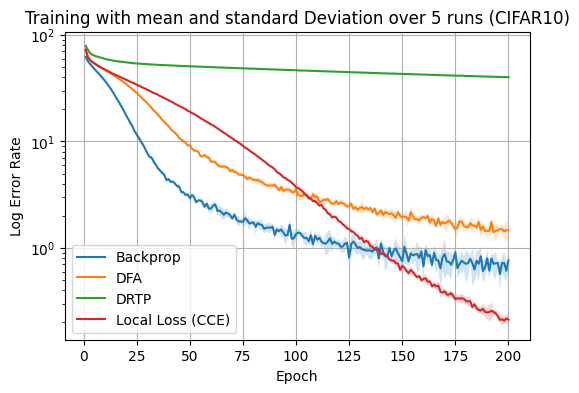

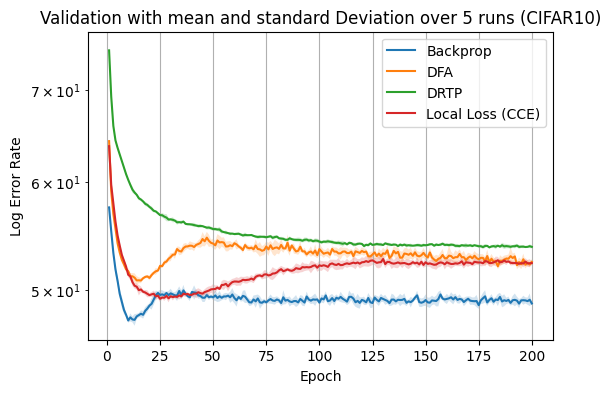

In [66]:
import matplotlib.pyplot as plt
import numpy as np

algos = ['Backprop', 'DFA', 'DRTP', 'Local Loss (CCE)']


def plot(metric):
    mean_losses = []
    std_losses = []
    
    for item in tuner.histories:
        hpset = item['hp']
        algo = hpset['algo']
        lr = hpset['lr']
        trials = item['histories']
        losses = np.array([run_history.history[metric] for run_history in trials])
        mean_loss = np.mean(losses, axis=0)
        std_loss = np.std(losses, axis=0)
        mean_losses.append(mean_loss)
        std_losses.append(std_loss)

    fig, ax = plt.subplots(figsize=(6, 4))

    epochs = np.arange(1, config.epochs + 1)

    for i, (mean_loss, std_loss) in enumerate(zip(mean_losses, std_losses)):
        plt.plot(epochs, mean_loss, label=algos[i])
        plt.fill_between(epochs, mean_loss - std_loss, mean_loss + std_loss, alpha=0.2)

    plt.xlabel('Epoch')
    plt.ylabel('Log Error Rate')
    plt.yscale('log')
    plt.title(f'{"Training" if "val" not in metric else "Validation"} with mean and standard Deviation '
              f'over {config.executions_per_trial} runs '
              f'({config.dataset.upper()})')
    plt.legend()
    plt.grid()
    plt.show()
    plt.close()
    
plot('error_rate')
plot('val_error_rate')

### Conclusion
Local loss outperforms backpropagation on training error as training proceeds, however, test error for local loss increases. This points to overfitting early on on the training set.

### Further experiments
This notebook shows a demo of how my framework for backpropagation free algorithms can be used. Similar experiments can be setup for reconstruction as well.